In [2]:
import pygmt
import obspy 
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm import tqdm
import os
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import time

from scipy.stats import pearsonr
import scipy.stats



In [3]:
iq_lats = pd.read_csv('icequakes_catalog.csv')['latitude']
iq_lons = pd.read_csv('icequakes_catalog.csv')['longitude']

eq_lats = pd.read_csv('earthquakes_catalog.csv')['latitude']
eq_lons = pd.read_csv('earthquakes_catalog.csv')['longitude']

stns = pd.read_csv('gmap-stations.txt', sep='|', skiprows=[2,6])


stations = stns.values[:,1].astype('str')
stn_lats = stns.values[:,2].astype('float')
stn_lons = stns.values[:,3].astype('float')
gl_lat, gl_lon = 61.219722, -146.895278

In [92]:
no_of_icequakes = []
no_of_earthquakes = []
for i in range(15):
    no_of_icequakes.append(len(glob('Data/icequake_waveforms/*'+stations[i]+'*')))
    no_of_earthquakes.append(len(glob('Data/earthquake_waveforms/*'+stations[i]+'*')))
    
    
total_events = np.array(no_of_icequakes)+np.array(no_of_earthquakes)
order = np.argsort(total_events)

### Performance of 7 Best stations combined in a single random forest model
RF model is trained and tested on all the data from the top performing 7 stations. "

In [4]:
stations = np.array(['GLI', 'SCM', 'SAW', 'KLU', 'FID', 'PWL', 'KNK'])

X_all = []
y_all = []
for i in tqdm(range(len(stations))):
    X_all.append(np.loadtxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/spectrum_features_1minute/"+stations[i]+".txt"))
    y_all.append(np.loadtxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/spectrum_features_1minute/"+stations[i]+"_labels.txt"))


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:17<00:00, 11.02s/it]


In [5]:
X = []
y = []

for i in tqdm(range(len(X_all))):
    for j in range(len(X_all[i])):
        X.append(X_all[i][j])
        y.append(y_all[i][j])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 253.52it/s]


In [43]:
acc = []
cf = []
cr = []

for i in tqdm(range(50)): ### taking 50 iterations
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(np.array(X)[:,60:901], y, 
                                                        test_size = 0.20, 
                                                        random_state = 101)
    #X_train_fs, X_test_fs, fs = select_features(X_Train, Y_Train, X_Test)

    start = time.process_time()
    trainedforest = RandomForestClassifier(n_estimators=50).fit(X_Train,Y_Train)
    dur = time.process_time() - start
    predictionforest = trainedforest.predict(X_Test)
    cf.append(confusion_matrix(Y_Test,predictionforest))
    cr.append(classification_report(Y_Test,predictionforest,output_dict=True ))
    acc.append(accuracy_score(Y_Test, predictionforest))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [45:10<00:00, 54.21s/it]


In [44]:
cf_mean = np.mean(cf,axis=0)

### Confusion matrix showing the average of 50 iterations

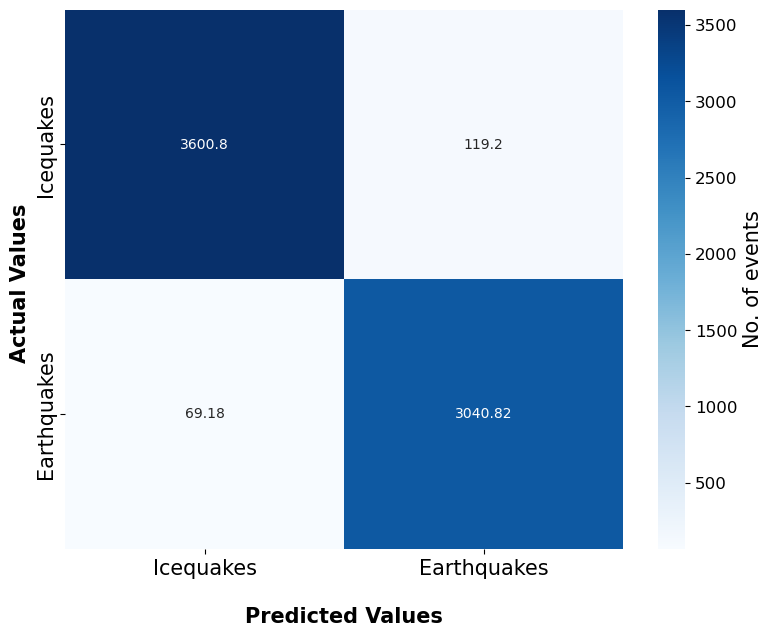

In [114]:
import seaborn as sns
plt.figure(figsize=[9,7])
ax = sns.heatmap(cf_mean, annot=True,fmt='', cmap = 'Blues',cbar_kws={'label': 'No. of events'})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label('No. of events', fontsize=15)

#ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values', fontsize=15, fontweight='bold')
ax.set_ylabel('Actual Values ', fontsize=15, fontweight='bold');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Icequakes','Earthquakes'], fontsize=15)
ax.yaxis.set_ticklabels(['Icequakes','Earthquakes'], fontsize=15)

## Display the visualization of the Confusion Matrix.
plt.savefig('Manuscript_Figures/Confusion_matrix.eps')

### Comparing the performance of the above multi-station model with individual stations

In [56]:
iq_lats = pd.read_csv('icequakes_catalog.csv')['latitude']
iq_lons = pd.read_csv('icequakes_catalog.csv')['longitude']

eq_lats = pd.read_csv('earthquakes_catalog.csv')['latitude']
eq_lons = pd.read_csv('earthquakes_catalog.csv')['longitude']

stns = pd.read_csv('gmap-stations.txt', sep='|', skiprows=[2,6])


stations = stns.values[:,1].astype('str')
stn_lats = stns.values[:,2].astype('float')
stn_lons = stns.values[:,3].astype('float')
gl_lat, gl_lon = 61.219722, -146.895278

In [58]:
cf_stations = []
cr_stations = []
acc_stations = []
for i in tqdm(range(len(stations))):
    X = np.loadtxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/spectrum_features_1minute/"+stations[i]+".txt")
    y = np.loadtxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/spectrum_features_1minute/"+stations[i]+"_labels.txt")
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(np.array(X)[:,60:901],y,test_size = 0.20, random_state = 101)
    #X_train_fs, X_test_fs, fs = select_features(X_Train, Y_Train, X_Test)
    trainedforest = RandomForestClassifier(n_estimators=50).fit(X_Train,Y_Train)
    dur = time.process_time() - start
    predictionforest = trainedforest.predict(X_Test)
    cf_stations.append(confusion_matrix(Y_Test,predictionforest))
    cr_stations.append(classification_report(Y_Test,predictionforest,output_dict=True ))
    acc_stations.append(accuracy_score(Y_Test, predictionforest))
        
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [02:50<00:00, 11.40s/it]


In [102]:
f1_combination = np.mean(np.array([cr[i]['macro avg']['f1-score'] for i in range(len(cr))]),axis=0)*100

In [62]:
f1_stations = np.array([cr_stations[i]['macro avg']['f1-score'] for i in range(15)])

## Comparing the f1-score of individual stations with the combination of stations

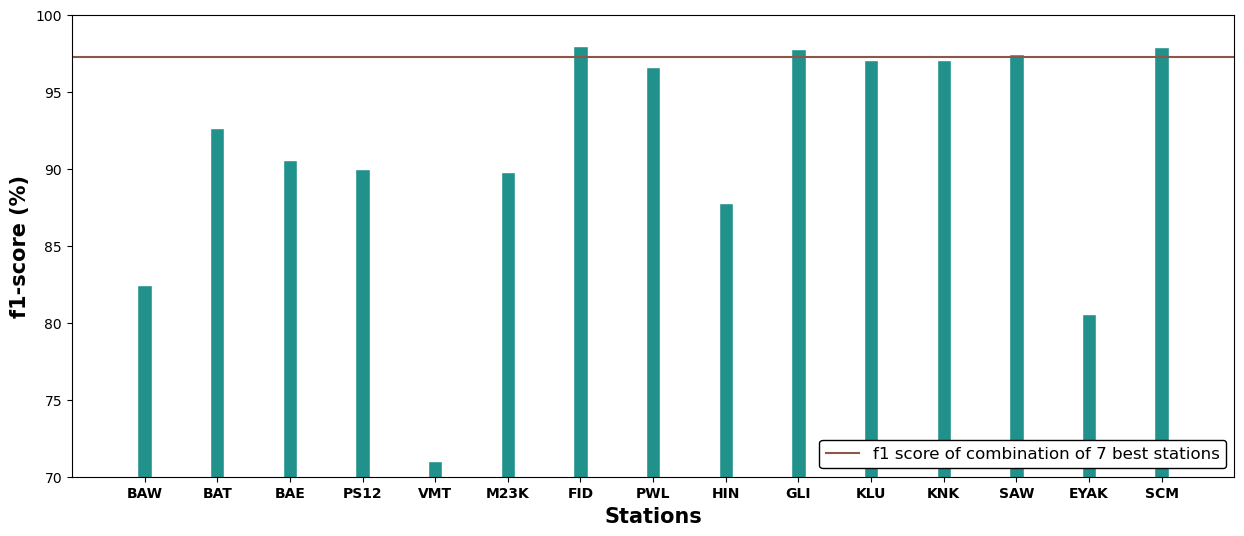

In [112]:
plt.style.use('default')
import numpy as np
import matplotlib.pyplot as plt


import matplotlib

cmap = matplotlib.cm.get_cmap('viridis')

c1 = cmap(0.1)
c2 = cmap(0.3)
c3 = cmap(0.5)
c4 = cmap(0.7)
c5 = cmap(0.9)
c6 = cmap(1.0)

a1 = f1_stations*100

# set width of bar
barWidth = 0.2
fig = plt.subplots(figsize =(15, 6), facecolor='white')
 



# Set position of bar on X axis
br1 = 1.0*np.arange(len(a1))


# Make the plot
plt.bar(br1, a1[order], color =c3, width = barWidth,edgecolor='w')

plt.axhline(f1_combination, color='C5', label='f1 score of combination of 7 best stations')



 
# Adding Xticks
plt.xlabel('Stations', fontweight ='bold', fontsize = 15)
plt.ylabel('f1-score (%)', fontweight ='bold', fontsize = 15)
plt.xticks(br1,stations[order], fontweight='black')
plt.ylim(70,100)
plt.xlim(-1,15)
plt.legend(loc='lower right',ncol=3, facecolor='white', framealpha=1, edgecolor='black', fontsize=12, )
plt.savefig(ConfusionConfusion)

## Confusion matrix for individual stations

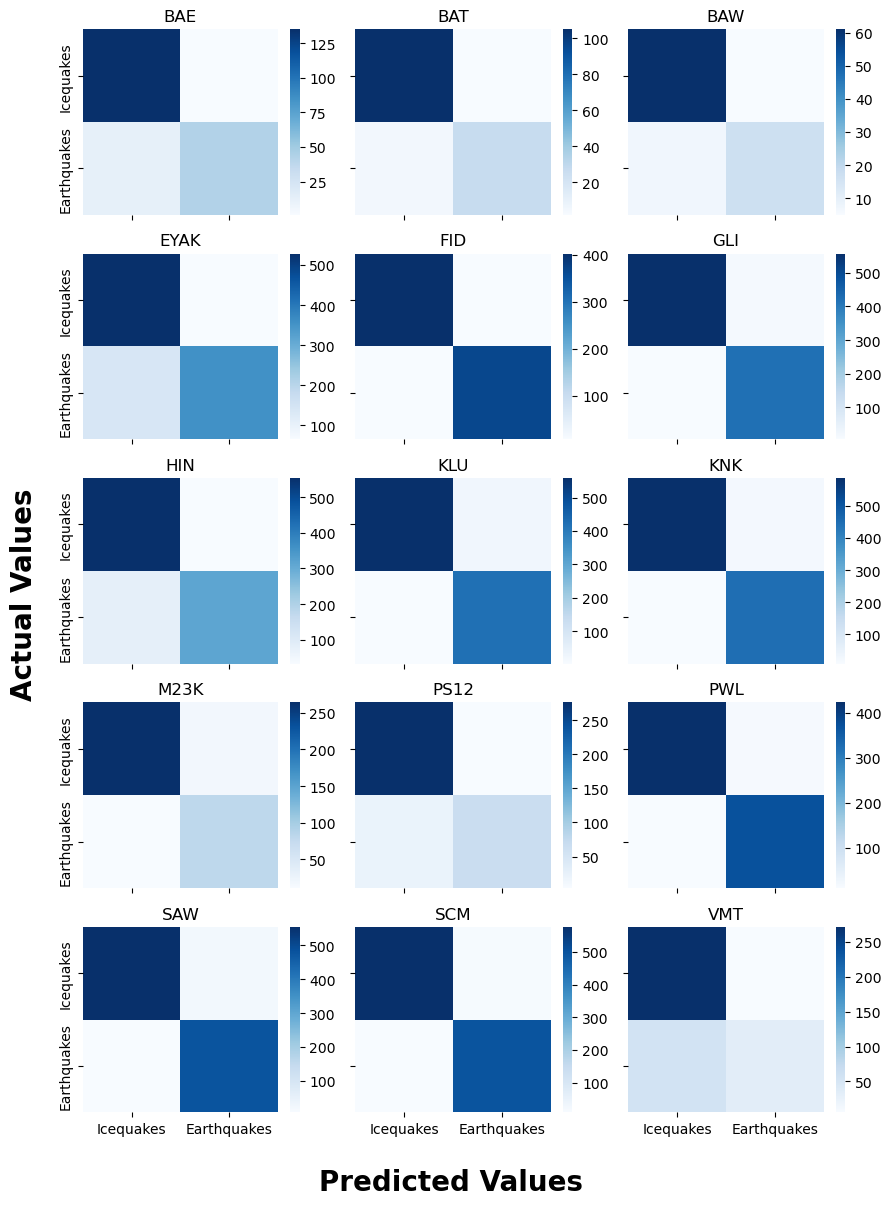

In [166]:
fig,axn = plt.subplots(5, 3, figsize=[9,12],sharex=True, sharey=True)

for i, ax in enumerate(axn.flat):
    sns.heatmap(cf_stations[i], ax=ax, cmap='Blues')
    ax.set_title(stations[i])
    ax.xaxis.set_ticklabels(['Icequakes','Earthquakes'], fontsize=10)
    ax.yaxis.set_ticklabels(['Icequakes','Earthquakes'], fontsize=10)

fig.supxlabel(y=0.01,t = 'Predicted Values',fontsize=20, fontweight='bold', va='center')
fig.supylabel(x = 0.01,t = 'Actual Values',fontsize=20, fontweight='bold', va='center')
plt.tight_layout()
plt.savefig('Manuscript_Figures/Confusion_matrix_stations.eps')

In [ ]:
Confusion

## Geographical variations in performance

In [167]:
size = []
size_eq = []
size_iq = []

for i in tqdm(range(len(stations))):
    size.append(len(glob('Data/icequake_waveforms/*'+stations[i]+'*'))+len(glob('Data/earthquake_waveforms/*'+stations[i]+'*')))
    size_iq.append(len(glob('Data/icequake_waveforms/*'+stations[i]+'*')))
    size_eq.append(len(glob('Data/earthquake_waveforms/*'+stations[i]+'*')))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.00it/s]


In [168]:
gl_lats = [61.22215, 61.23980, 61.28859, 61.38921]
gl_lons = [-146.89464,-147.41556, -147.47800,-147.43615]
from obspy.geodetics.base import gps2dist_azimuth

dist1 = []
dist2 = []
dist3 = []
dist4 = []


for i in range(len(stn_lats)):
    dist1.append(gps2dist_azimuth(stn_lats[i], stn_lons[i], gl_lats[0], gl_lons[0])[0]/1000)
    dist2.append(gps2dist_azimuth(stn_lats[i], stn_lons[i], gl_lats[1], gl_lons[1])[0]/1000)
    dist3.append(gps2dist_azimuth(stn_lats[i], stn_lons[i], gl_lats[2], gl_lons[2])[0]/1000)
    dist4.append(gps2dist_azimuth(stn_lats[i], stn_lons[i], gl_lats[3], gl_lons[3])[0]/1000)

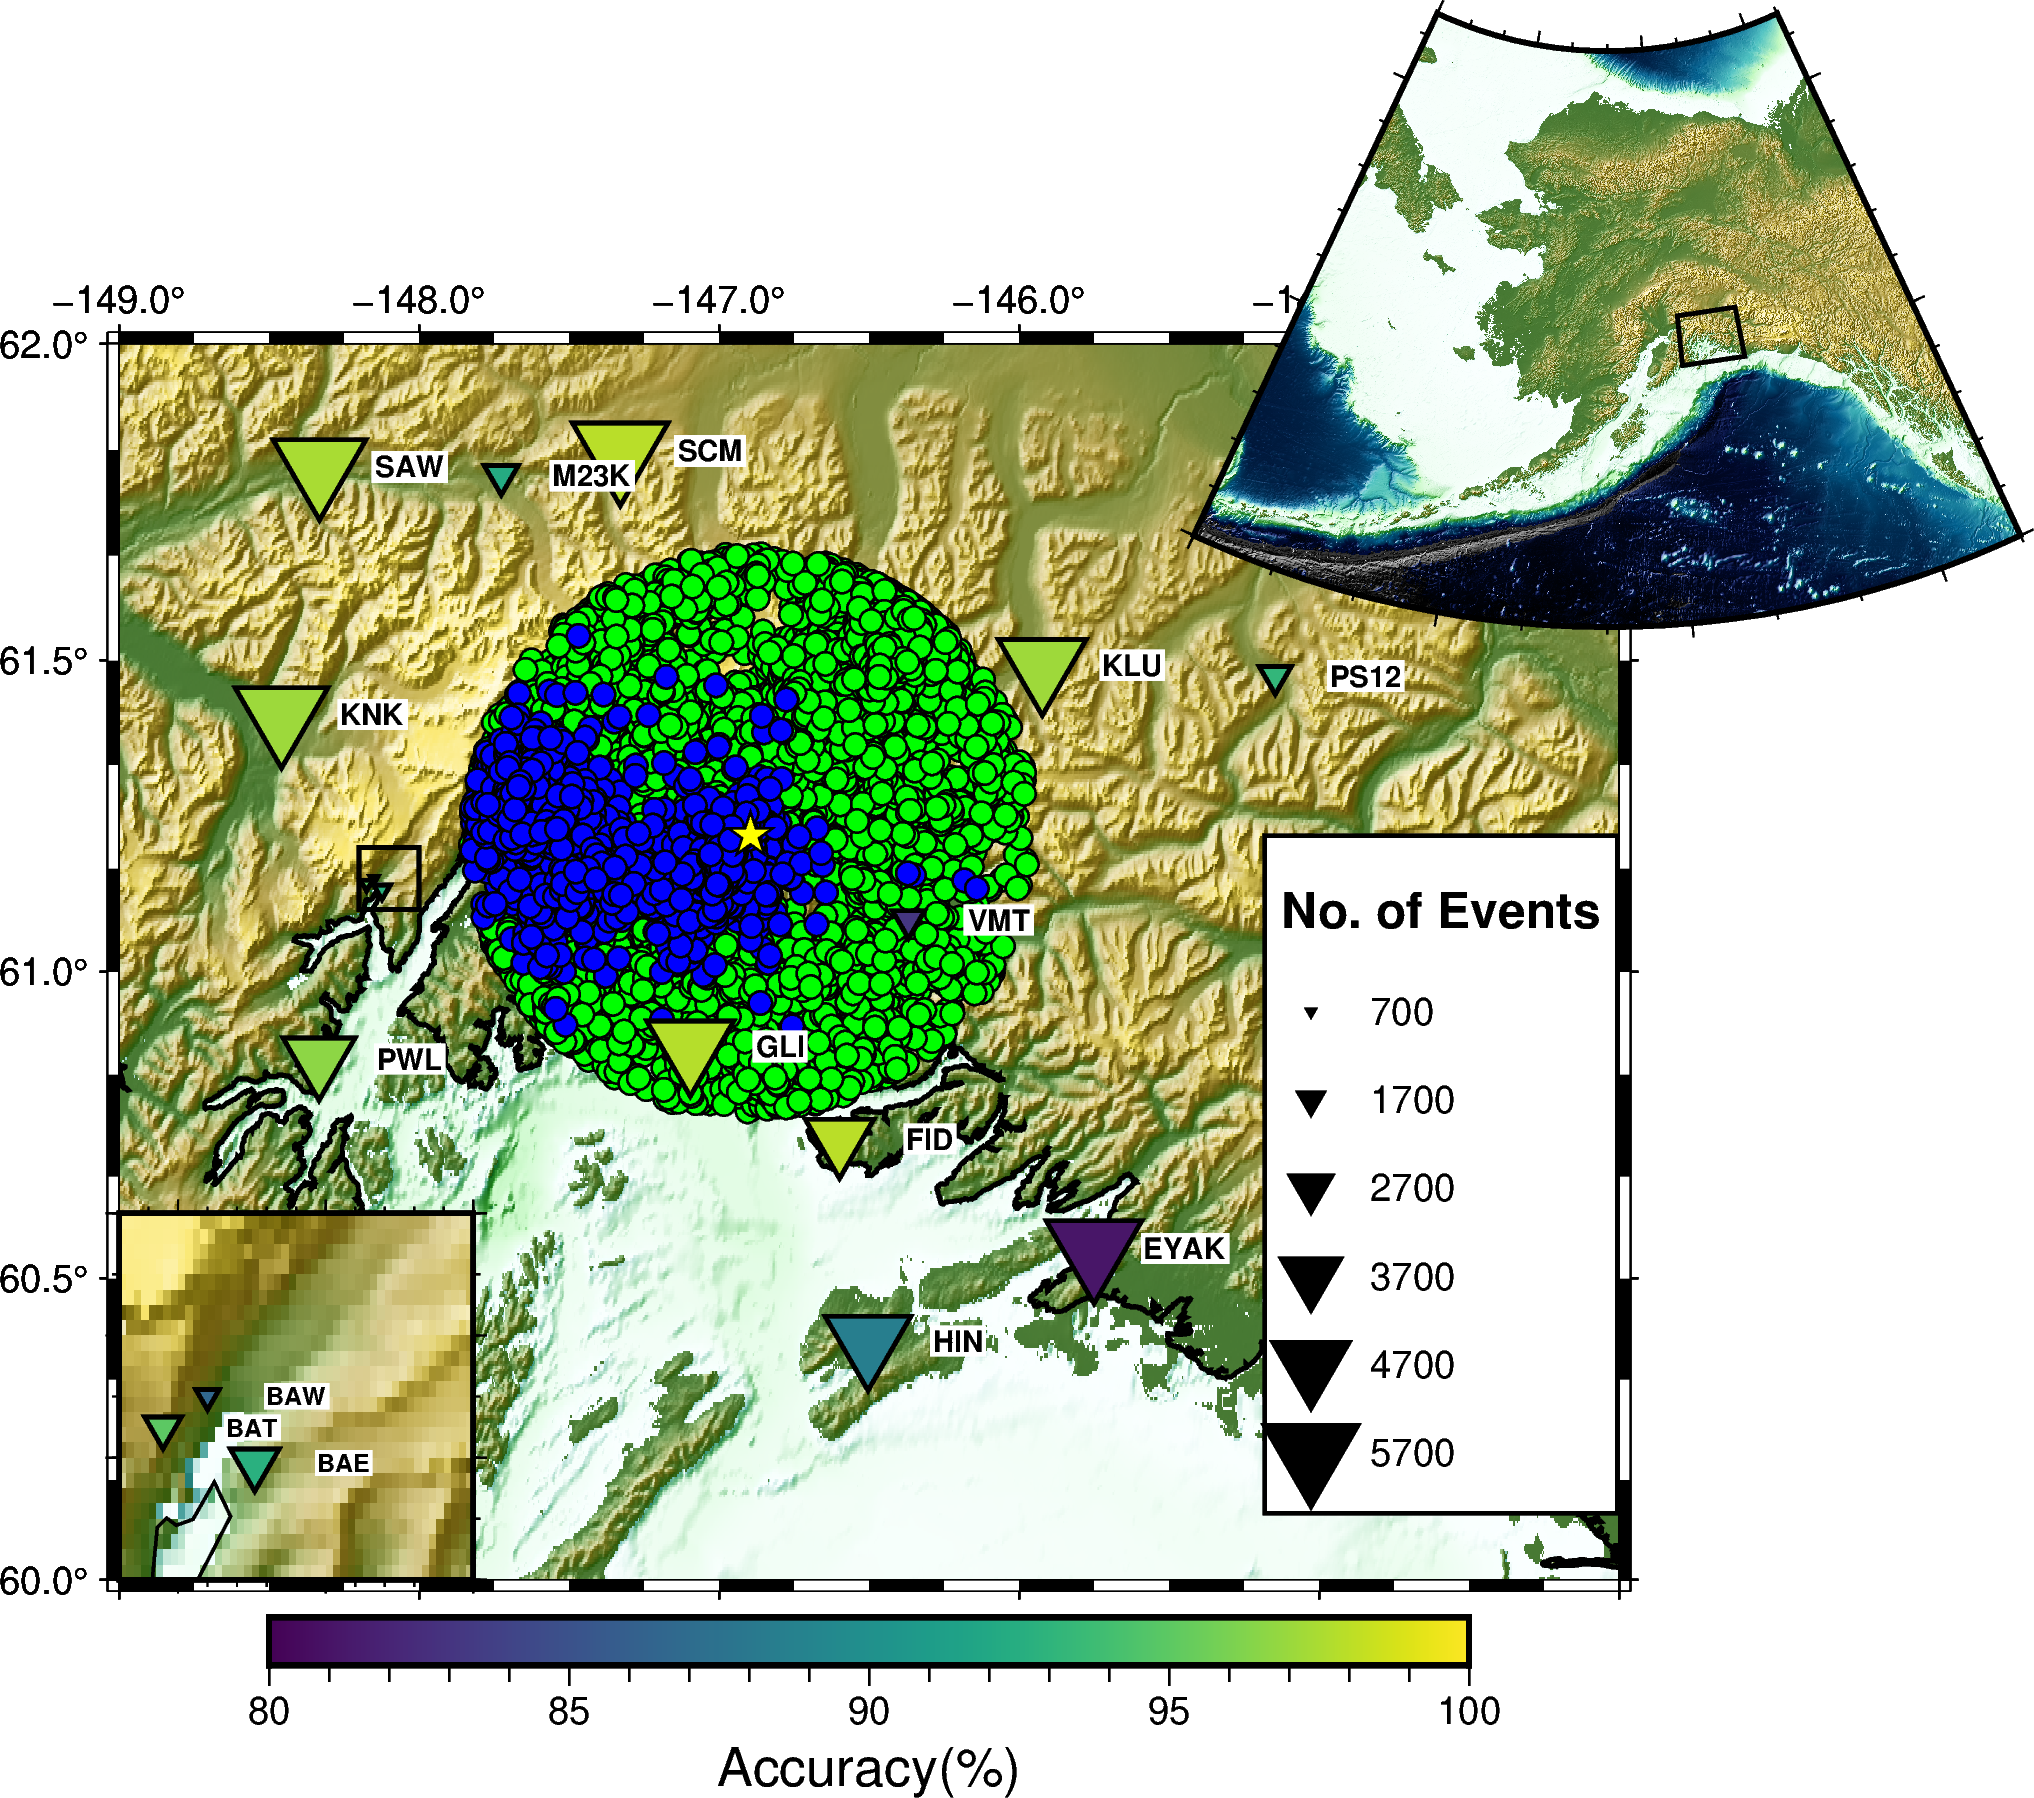

In [170]:
region = [-149.0, -144, 60, 62]
fig = pygmt.Figure()
pygmt.makecpt(cmap='relief',series='-5000/5000/1000',continuous=True)
topo_data = '@earth_relief_15s'
pygmt.config(FORMAT_GEO_MAP="ddd.x")
fig.grdimage(grid=topo_data,region=region,projection='M5i',shading=True,cmap=True,
            frame=["WsNe", "xaf", "yaf"])
#pygmt.makecpt(cmap="plasma", series=[np.min(depths),25])
fig.coast(area_thresh = 10000,
    shorelines='1p,black',
#          water="lightblue",
          region=region,
#          borders="1/thick",
         frame=["WsNe", "xaf", "yaf"], 
          map_scale='"g85/8+w200"')


pygmt.makecpt(cmap="viridis", series = [80,100])

fig.plot(x=eq_lons,y=eq_lats,style='c0.2c',color='green',pen='0.5p,black',
         region=region,transparency=0)
fig.plot(x=iq_lons,y=iq_lats,style='c0.2c',color='blue',pen='0.5p,black',
         region=region,transparency=0)
fig.plot(x=stn_lons,y=stn_lats,style='ic',size = (np.array(size)*(0.00017)),color=np.array(acc_stations)*100,pen='1p,black',
         region=region, cmap=True,)

fig.plot(x=gl_lon,y=gl_lat,style='a0.4c',color='yellow',pen='0.5p,black',
         region=region)
fig.text(text=stations[3:],y=stn_lats[3:]+0.00,x=stn_lons[3:]+0.30,font="7p,Helvetica-Bold,black",fill='white')
fig.colorbar(frame='af+l"Accuracy(%)"')

region1 = [-148.2,-148,61.1,61.2]
rectangle = [[region1[0], region1[2], region1[1], region1[3]]]
fig.plot(data=rectangle, style="r+s", pen="1p,black",projection='M5i')
fig.legend(spec='Legend.txt',position='JBR+jTL+l2.3c+o-3.0c/-6.3c',box='+gwhite+p1p')

with fig.inset(position="jBL+w2c+o-0.0c/-0.0c", box=False,no_clip=True):
    # Plot the Japan main land in the inset using coast. "U54S/?" means UTM
    # projection with map width automatically determined from the inset width.
    # Highlight the Japan area in "lightbrown"
    # and draw its outline with a pen of "0.2p".
    topo_data = '@earth_relief_15s'
    proj = "M3c"
    pygmt.makecpt(cmap='relief',series='-5000/5000/1000',continuous=True)
    fig.grdimage(grid=topo_data, region=region1,projection=proj,shading=True,            
                 frame=["wsne", "xaf", "yaf"], cmap=True)
    
    pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain")
    #rectangle = [[region[0], region[2], region[1], region[3]]]
    #fig.plot(data=rectangle, style="r+s", pen="2p,blue",projection=proj)
    fig.coast(area_thresh = 10000,
        region=region1,
        projection=proj,
        borders=["2/thin","1/thin"],
        shorelines="thin",
#        water="azure1",
#        land= 'lightyellow',
        frame=["wsne"],
        resolution = 'h')
    pygmt.makecpt(cmap="viridis", series = [80,100])
    fig.plot(x=stn_lons,projection=proj, y=stn_lats,style='ic',size = (np.array(size)*(0.0005)),color=np.array(acc_stations)*100,pen='1p,black',
         region=region1, cmap=True,)
    fig.text(text=stations,y=stn_lats+0.00,x=stn_lons+0.05,region=region1, projection=proj, font="6p,Helvetica-Bold,black",fill='white')
    #fig.plot(data=rectangle, style="r+s", pen="1p,blue",projection=proj)

    
region2 = [-180, -130, 50, 73]    
with fig.inset(position="jTR+w2c+o1.6c/0.4c", box=False,no_clip=True):
    # Plot the Japan main land in the inset using coast. "U54S/?" means UTM
    # projection with map width automatically determined from the inset width.
    # Highlight the Japan area in "lightbrown"
    # and draw its outline with a pen of "0.2p".
    topo_data = '@earth_relief_01m'
    proj = 'S-155/90/7c'
    pygmt.makecpt(cmap='relief',series='-5000/5000/1000',continuous=True)
    fig.grdimage(grid=topo_data, region=region2,projection=proj,shading=True,            
                 frame=["wsne", "xaf", "yaf"], cmap=True)
    
    pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain")
    rectangle = [[region[0], region[2], region[1], region[3]]]
    #fig.plot(data=rectangle, style="r+s", pen="2p,blue",projection=proj)
    '''fig.coast(area_thresh = 10000,
        region=region2,
        projection=proj,
        borders=["2/thin","1/thin"],
        shorelines="thin",
#        water="azure1",
#        land= 'lightyellow',
        frame=["wsne"],
        resolution = 'l')
        
    #pygmt.makecpt(cmap="plasma", series = [70,100])
    #fig.plot(x=stn_lons,projection=proj, y=stn_lats,style='ic',size = (np.array(size)*(0.0005)),color=np.array(accuracy_1_10_modified_pca)*100,pen='1p,black',
    #     region=region1, cmap=True,)
    #fig.text(text=stations,y=stn_lats+0.00,x=stn_lons+0.05,region=region1, projection=proj, font="6p,Helvetica-Bold,black",fill='white')
    fig.plot(data=rectangle, style="r+s", pen="1p,blue",projection=proj)
    '''
    fig.plot(data=rectangle, style="r+s", pen="1p,black",projection=proj)
    
fig.show()
fig.savefig('Manuscript_Figures/Map_Variations.eps')

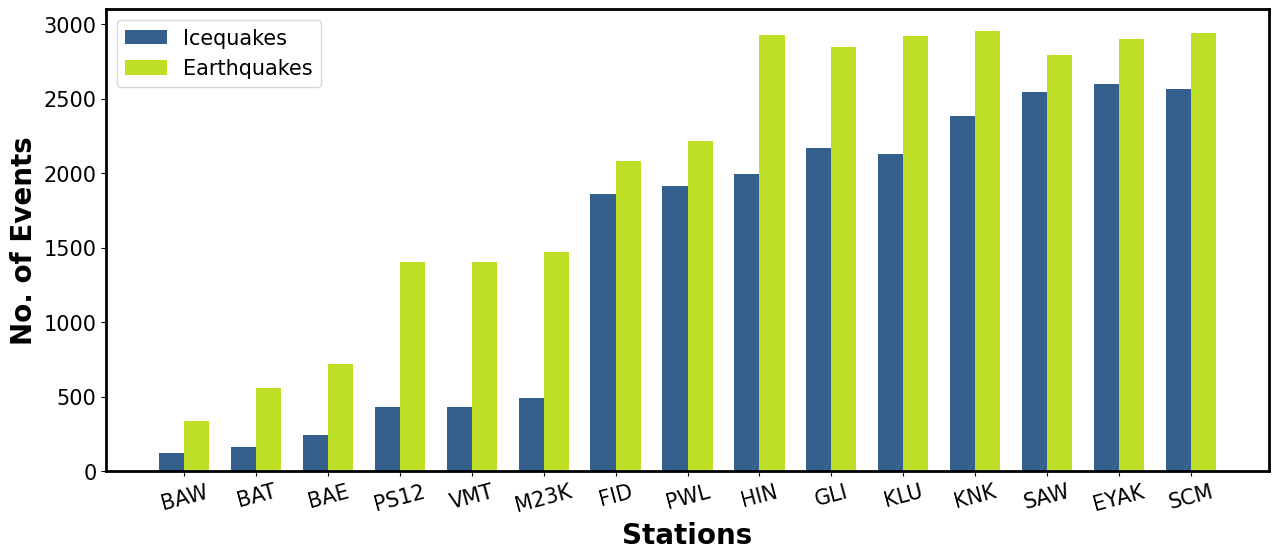

In [97]:
import matplotlib
cmap = matplotlib.cm.get_cmap('viridis')
c1 = cmap(0.1)
c2 = cmap(0.3)
c3 = cmap(0.5)
c4 = cmap(0.7)
c5 = cmap(0.9)
c6 = cmap(1.0)

plt.rcParams['axes.linewidth'] = 2
fig, ax = plt.subplots(1,1,figsize=[15,6])

x = np.arange(len(stations))
width = 0.35

rects1 = ax.bar(x - width/2, np.array(no_of_icequakes)[order], width, label='Icequakes', color=c2)
rects2 = ax.bar(x + width/2, np.array(no_of_earthquakes)[order], width, label='Earthquakes', color=c5)
ax.set_ylabel('No. of Events', fontsize=20, weight='bold')
ax.set_xlabel('Stations', fontsize=20, weight='bold')
ax.set_xticks(x)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xticklabels(labels=stations[order], rotation=15, size=15)
ax.legend(fontsize=15)